# **ML1 PROJECT 3** <br/>
Kati Schuerger, Will Sherman, Randy Kim

# **INTRODUCTION** <br/>
*Assingment: This section is not part of the rubric; meaning, there is no formal assignment for this "introduction" section. This can be used to provide some additional information regarding what the reader can find in the following project.*

<div class="alert alert-block alert-info">
<b><h2>Rubric Components</h2>
    </b>
</div>

<a id='TOP'></a>

• [Business Understanding](#BUSINESS_UNDERSTANDING)

• [Data Understanding 1](#DATA_UNDERSTANDING_1)

• [Data Understanding 2](#DATA_UNDERSTANDING_2)

• [Modeling and Evaluation 1](#ME1)

• [Modeling and Evaluation 2](#ME2)

• [Modeling and Evaluation 3](#ME3)

• [Modeling and Evaluation 4](#ME4)

• [Deployment](#DEPLOYMENT)

• [Exceptional Work](#EXCEPTIONAL)

• [Appendix](#APPENDIX)

## PROJECT OBJECTIVES

### Prediction task

We will be building our models to solve a classification problem (classification task) = predict `quart_binary` (0/1). This variable is equal to 1 when the player's score is in the 4th quantile.

### Data volume <br/>
*Try to use as much testing data as possible in a realistic manner.*

For hyperparameter tuning, we used a subset of our training data, because we ran into very lengthy run-time when attempting to perform tuning on the full training set. To help decrease the run-time, a subsample of 10% of the train data was made. This will still represent about 270,000 records, which is sufficient for our analysis and modeling. 

As long as the sample size is greater than 30, we can leverage the CLT, which allows us to make inferences about our population by using a sampling of the data.

<a id='BUSINESS_UNDERSTANDING'></a>

# **BUSINESS UNDERSTANDING**

Jump to [Top](#TOP)

*Assignment: Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific
dataset and the stakeholders needs?*

The **PlayerUnknown’s Battleground** (also known as PUBG) **Finish Placement Prediction** Kaggle competition was posted to "create a model which predicts players' finishing placement based on their final stats, on a scale from 1 (first place) to 0 (last place)." This competition utilized publicly available official game data from PUBG through the PUBG Developer API. The questions of interest (QOI) were about the best strategy to win in PUBG, the best skillset, and to be able to model ranking in-game. The dataset provided was a breakdown of post-game metrics and percentile winning placement: with 4446966 records and 29 total features.

https://www.kaggle.com/c/pubg-finish-placement-prediction/data

Utilizing the `winPlacePerc` (continuous variable), our approach was to create a binary prediction evaluation: `quart_binary` (categorical variable). `winPlacePerc` is a ranking of a "players' finishing placement based on their final stats, on a scale from 1 (first place) to 0 (last place)." `quart_binary` will be utilized for evaluating whether clustering improves prediction capability.

For this clustering and classification task, we will measure accuracy in combination with 10-fold cross-validation.

Possible uses:

"Creating forecasting algorithms for online sports is not new. Therefore, the combination of the two measures could be related to optimizing a sports betting algorithms. You could also use these models for building and managing an effective team for tournaments. For example, the PUBG Global Championship 2021 Grand Finals had combined prize value of over 2 million USD." (Kim, Schuerger, Sherman. Lab 1)

# **DATA UNDERSTANDING 1**

<a id='DATA_UNDERSTANDING_1'></a>

*Assignment: Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?*

## DATA PRE-PROCESSING 1

Jump to [Top](#TOP)

### Set up environment

In [1]:
# load libraries
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import model_selection
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn import metrics as mt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import statistics
import time

# import libraries to clean up CopyWarning
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

### Load in data

In [2]:
# load in the data
pubg_raw = pd.read_csv("train_V2.csv")

# for kati local run
# pubg_raw = pd.read_csv(r"C:\Users\kschue200\OneDrive - Comcast\Documents\00 SMU\00 machine learning1\mini lab\train_V2.csv")

# for will local run
# pubg_raw = pd.read_csv(r"C:\Users\sherm\OneDrive\Documents\Grad School - Classes\MSDS - 7331 - Machine Learning I\Lab 1\pubg-finish-placement-prediction\train_V2.csv")

### Reduce memory usage

In [3]:
# this logic iterates through the x_tune to reduce memory usage
# code adapted from https://www.kaggle.com/yansun1996/gbr-ipynb
# additional reference: https://www.kaggle.com/gemartin/load-data-reduce-memory-usage

def reduce_mem_usage(df):
    '''
    iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.        
    '''
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
pubg_raw = reduce_mem_usage(pubg_raw)

Memory usage of dataframe is 983.90 MB
Memory usage after optimization is: 288.39 MB
Decreased by 70.7%


We have utilized the above to help reduce memory usage & improve run-times.

In [5]:
import random
random.seed(10) #set seed

## DATA PRE-PROCESSING 2

Jump to [Top](#TOP)

In [6]:
pubg_raw.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00000,0,0,0,60,...,0,0.000000,0,0.000000,0,0,244.75,1,1466,0.444336
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,57,...,0,0.004501,0,11.039062,0,0,1434.00,5,0,0.640137
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,...,0,0.000000,0,0.000000,0,0,161.75,2,0,0.775391
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,...,0,0.000000,0,0.000000,0,0,202.75,3,0,0.166748
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,...,0,0.000000,0,0.000000,0,0,49.75,2,0,0.187500


### Check for missing values

In [7]:
# check for misssing values
colname = list(pubg_raw.columns)

for i in range(len(pubg_raw.columns)):
  count = pubg_raw[pubg_raw.columns[i]].isna().sum()
  print("Column '{col}' has {ct} NAs".format(col = colname[i], ct = count))

Column 'Id' has 0 NAs
Column 'groupId' has 0 NAs
Column 'matchId' has 0 NAs
Column 'assists' has 0 NAs
Column 'boosts' has 0 NAs
Column 'damageDealt' has 0 NAs
Column 'DBNOs' has 0 NAs
Column 'headshotKills' has 0 NAs
Column 'heals' has 0 NAs
Column 'killPlace' has 0 NAs
Column 'killPoints' has 0 NAs
Column 'kills' has 0 NAs
Column 'killStreaks' has 0 NAs
Column 'longestKill' has 0 NAs
Column 'matchDuration' has 0 NAs
Column 'matchType' has 0 NAs
Column 'maxPlace' has 0 NAs
Column 'numGroups' has 0 NAs
Column 'rankPoints' has 0 NAs
Column 'revives' has 0 NAs
Column 'rideDistance' has 0 NAs
Column 'roadKills' has 0 NAs
Column 'swimDistance' has 0 NAs
Column 'teamKills' has 0 NAs
Column 'vehicleDestroys' has 0 NAs
Column 'walkDistance' has 0 NAs
Column 'weaponsAcquired' has 0 NAs
Column 'winPoints' has 0 NAs
Column 'winPlacePerc' has 1 NAs


In [8]:
# look at records with null values
pubg_raw[pubg_raw.isna().any(axis = 1)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


There was one missing value in `winPlacePerc` that was due to a single instance of a player who had a match with no enemy combatants. Therefore, a `winPlacePerc` was not evaluated.

In [9]:
# CREATE PUBG_DF_STG TO INCLUDE OUR UPDATES
# drop records with missing values (there is only one)
pubg_df_stg = pubg_raw.dropna()
pubg_df_stg.isnull().values.any()

False

Based on our analysis, we dropped the single missing value for a match that had only 1 individual (above).

We also identified **unranked** matches as creating significant issues in prediction capabilities (below). There wer matches with `rankPoints` with values of  '-1'. We resolved to remove these from our model. Therefore, our model should only be applied to **ranked** matches. 

In [10]:
# we have some records with -1 values = these take the place of NULL

x = pubg_df_stg['rankPoints']
y = pubg_df_stg['winPoints']
z = pubg_df_stg['killPoints']

print(x[x==-1].count())
print(y[y==-1].count())
print(z[z==-1].count())
print(pubg_df_stg.shape[0]-x[x==-1].count())

1701810
0
0
2745155


### Subset data - Ranked matches only

In [11]:
# SUBSET OUR DATA TO ONLY RETAIN RANKED MATCHES
# we have some records with -1 values = take the place of NULL
## dropping these to subset our dataset & because they represent non-ranked matches

pubg_df = pubg_df_stg[(pubg_df_stg.iloc[:,:] != -1).all(axis=1)]
pubg_df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,57,...,0,0.004501,0,11.039062,0,0,1434.0000,5,0,0.640137
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,...,0,0.000000,0,0.000000,0,0,161.7500,2,0,0.775391
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,...,0,0.000000,0,0.000000,0,0,202.7500,3,0,0.166748
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,...,0,0.000000,0,0.000000,0,0,49.7500,2,0,0.187500
5,ff79c12f326506,289a6836a88d27,bac52627a12114,0,0,100.00000,1,1,0,44,...,0,0.000000,0,0.000000,0,0,34.6875,1,0,0.036987


### Check for duplicate values

In [12]:
# check for duplicate records
pubg_df.duplicated().any()

False

There do not appear to be any duplicate records.

### Create new features = quartiles

In [13]:
# GATHER THRESHOLDS FOR US TO SET OUR QARTILES 
# pull out the winPlacePerc column
winPlace = pubg_df.loc[:,'winPlacePerc']

# get quartile thresholds for equal allocation |
print('Quartile 1 threshold: {:.2f}'.format(winPlace.quantile(0.25)))
print('Quartile 2 threshold: {:.2f}'.format(winPlace.quantile(0.5)))
print('Quartile 3 threshold: {:.2f}'.format(winPlace.quantile(0.75)))

Quartile 1 threshold: 0.20
Quartile 2 threshold: 0.46
Quartile 3 threshold: 0.74


In [14]:
# create new variable fields to use for our predictions (quartile, quart_int, quart_binary)
# we will use quart_binary for our classification task in this mini-lab

pubg_df['quartile'] = np.where(pubg_df.winPlacePerc < 0.20, 'q1', 
                       np.where(pubg_df.winPlacePerc < 0.46, 'q2',
                                np.where(pubg_df.winPlacePerc < 0.74, 'q3',
                                         np.where(pubg_df.winPlacePerc >= 0.74, 'q4',
                                                  'other'))))
pubg_df['quart_int'] = np.where(pubg_df.winPlacePerc < 0.20, '1', 
                       np.where(pubg_df.winPlacePerc < 0.46, '2',
                                np.where(pubg_df.winPlacePerc < 0.74, '3',
                                         np.where(pubg_df.winPlacePerc >= 0.74, '4',
                                                  'other'))))
pubg_df['quart_binary'] = np.where(pubg_df.winPlacePerc < 0.74, '0',
                                         np.where(pubg_df.winPlacePerc >= 0.74, '1',
                                                  'other'))
pubg_df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,quartile,quart_int,quart_binary
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,57,...,11.039062,0,0,1434.0000,5,0,0.640137,q3,3,0
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,...,0.000000,0,0,161.7500,2,0,0.775391,q4,4,1
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,...,0.000000,0,0,202.7500,3,0,0.166748,q1,1,0
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,...,0.000000,0,0,49.7500,2,0,0.187500,q1,1,0
5,ff79c12f326506,289a6836a88d27,bac52627a12114,0,0,100.00000,1,1,0,44,...,0.000000,0,0,34.6875,1,0,0.036987,q1,1,0


In [15]:
# check the spread of our quartiles
# make sure they are balanced

quartiles = np.append(sorted(pubg_df.quartile.unique()), 'other')
e = 1

for i in quartiles:
    if e < len(quartiles):
        count = len(pubg_df[pubg_df.quartile == i])
        print('Percentage of players in Quartile {}: {:.2f}%'.format(e, 
                                                                 (count / (len(pubg_df.quartile))*100)))
        e += 1
    else:
        count = len(pubg_df[pubg_df.quartile == i])
        print('Miscategorized quartile values:  ', count)

Percentage of players in Quartile 1: 24.86%
Percentage of players in Quartile 2: 25.19%
Percentage of players in Quartile 3: 24.55%
Percentage of players in Quartile 4: 25.41%
Miscategorized quartile values:   0


### Remove unuseful variables

In [16]:
# remove some unuseful object-datatype variables 
del pubg_df['Id']
del pubg_df['groupId']
del pubg_df['matchId']
# del pubg_df['matchType'] # <-- we will leave in for now

The above features are specific to individuals & will not be useful for the QOI: predicting players' finishing placement based on their stats.

### Evaluate outliers

We will evaluate outliers by looking at the **data shape** for each of our attributes.

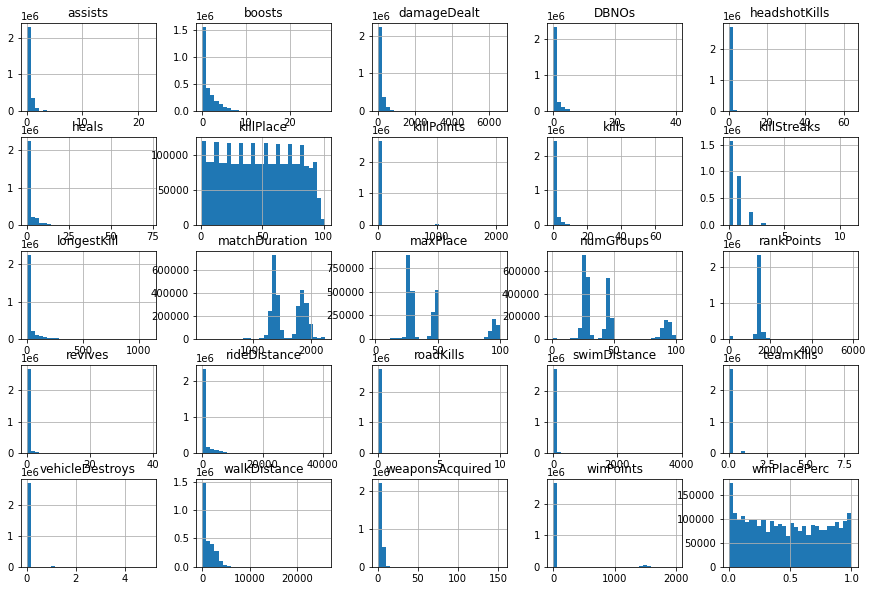

In [17]:
in_plot = pubg_df.hist(bins=30, figsize = (15, 10))[2]

Much of the data appears to be right-skewed, which also means we are likely to have many "outliers". This may impact our ability to run analytics unless we normalize and/or standardize our data.

There are a few notable exceptions: `matchDuration`, `maxPlace`, and `numGroups`. These appear to be either bimodal or trimodal with `matchDuration` being fairly centered on the mean but `maxPlace` and `numGroups` again exhibiting right-skew.

Therefore, our approach will be to evaluate clustering by first utilizing *principal component analysis* (PCA).

### New features <br/>
Let's create some new features that we could use in our modeling later on.

In [18]:
pubg_df['totalDistance'] = pubg_df['rideDistance'] + pubg_df['swimDistance'] + pubg_df['walkDistance']
pubg_df['killsAssist'] = pubg_df['kills'] + pubg_df['assists']
pubg_df['totalItems'] = pubg_df['heals'] + pubg_df['boosts'] + pubg_df['weaponsAcquired']
pubg_df['healItems'] = pubg_df['heals'] + pubg_df['boosts']
# pubg_df['MMR'] = pubg_df['killPoints'] + pubg_df['winPoints'] # + pubg_df['rankPoints'] <- may take out rank points as it depends on killPoints & winPoints

**PLEASE NOTE: Data Scale and Descriptions provided in "Appendix" at the end of this notebook.** <br/>

### Create object with feature column names

In [19]:
# FEATURE COLUMN NAMES (create cols_df)
# make a list of the columns in our df (to be used for models below)

cols_df = pubg_df.columns.values.tolist()
cols_df.remove('winPlacePerc') # remove target variable 1 (continuous)
cols_df.remove('quartile') # remove target variable 2 (categorical)
cols_df.remove('quart_int') # remove target variable 2 (numeric representation)
cols_df.remove('quart_binary')
# print(cols_df)

In [20]:
# remove additional variables that are causing extra noise in our model
# (specifically, these variables are highly correlated with other variables 
# which impacts our model's convergence perfomance)

cols_df.remove('winPoints') # highly correlated with rankPoints and killPoints
cols_df.remove('killPoints') # highly correlated with rabnkPoints and winPoints
cols_df.remove('maxPlace') # perfectly correlated with numGroups
# print(cols_df)

# We maintain the rankPoints variable since we subset on this earlier to only work with 'ranked' matches

In [21]:
# remove matchType = causes issues when we scale data for PCA

del pubg_df['matchType']
# del finalDF['matchType']
cols_df.remove('matchType')

In [22]:
# print cols_df (feature columns to be used in models)
print(cols_df)

['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals', 'killPlace', 'kills', 'killStreaks', 'longestKill', 'matchDuration', 'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills', 'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'totalDistance', 'killsAssist', 'totalItems', 'healItems']


## FINAL DATAFRAME

Jump to [Top](#TOP)

The below df.info() confirms that we have at least 30k records and 15 columns in data. We have 2,745,155 records and 21 feature columns—2 response vectors.

In [23]:
temp = pubg_df[cols_df]
temp['winPlacePerc'] = pubg_df['winPlacePerc']
temp['quart_binary'] = pubg_df['quart_binary']
finalDF = temp
finalDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2745155 entries, 1 to 4446965
Data columns (total 27 columns):
 #   Column           Dtype  
---  ------           -----  
 0   assists          int8   
 1   boosts           int8   
 2   damageDealt      float16
 3   DBNOs            int8   
 4   headshotKills    int8   
 5   heals            int8   
 6   killPlace        int8   
 7   kills            int8   
 8   killStreaks      int8   
 9   longestKill      float16
 10  matchDuration    int16  
 11  numGroups        int8   
 12  rankPoints       int16  
 13  revives          int8   
 14  rideDistance     float16
 15  roadKills        int8   
 16  swimDistance     float16
 17  teamKills        int8   
 18  vehicleDestroys  int8   
 19  walkDistance     float16
 20  weaponsAcquired  int16  
 21  totalDistance    float16
 22  killsAssist      int8   
 23  totalItems       int16  
 24  healItems        int8   
 25  winPlacePerc     float16
 26  quart_binary     object 
dtypes: float16(7

<a id='DATA_UNDERSTANDING_2'></a>

# **DATA UNDERSTANDING 2**

*Assignment: Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.*

## SIMPLE STATISTICS

Jump to [Top](#TOP)

Because most of our data is continuous (either integers or floats), a large amount of our data can be evaluated for simple statistical measures.

In [24]:
stats = finalDF.describe()
stats

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,kills,killStreaks,longestKill,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,totalDistance,killsAssist,totalItems,healItems,winPlacePerc
count,2.745155e+06,2.745155e+06,2745155.00,2.745155e+06,2.745155e+06,2.745155e+06,2.745155e+06,2.745155e+06,2.745155e+06,2.745155e+06,...,2745155.0,2.745155e+06,2.745155e+06,2745155.000,2.745155e+06,2745155.00,2.745155e+06,2.745155e+06,2.745155e+06,2.745155e+06
mean,2.237921e-01,1.123926e+00,NaN,6.490603e-01,2.259672e-01,1.398382e+00,4.751563e+01,9.219162e-01,5.412292e-01,NaN,...,NaN,2.903151e-02,8.756154e-03,NaN,3.676111e+00,NaN,1.145708e+00,6.198419e+00,2.522308e+00,NaN
std,5.763510e-01,1.735702e+00,NaN,1.134096e+00,5.980902e-01,2.725667e+00,2.741419e+01,1.551348e+00,7.063531e-01,NaN,...,NaN,1.815228e-01,9.752691e-02,NaN,2.453115e+00,NaN,1.819689e+00,5.401557e+00,3.939304e+00,0.000000e+00
min,0.000000e+00,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.000000e+00,0.000000e+00,0.000,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.000000e+00,0.000000e+00,157.875,2.000000e+00,161.25,0.000000e+00,2.000000e+00,0.000000e+00,1.999512e-01
50%,0.000000e+00,0.000000e+00,82.25,0.000000e+00,0.000000e+00,0.000000e+00,4.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.000000e+00,0.000000e+00,695.500,3.000000e+00,807.50,0.000000e+00,5.000000e+00,1.000000e+00,4.582520e-01
75%,0.000000e+00,2.000000e+00,184.00,1.000000e+00,0.000000e+00,2.000000e+00,7.100000e+01,1.000000e+00,1.000000e+00,2.167188e+01,...,0.0,0.000000e+00,0.000000e+00,1980.000,5.000000e+00,2792.00,2.000000e+00,9.000000e+00,4.000000e+00,7.407227e-01
max,2.200000e+01,2.800000e+01,6616.00,4.000000e+01,6.400000e+01,7.300000e+01,1.010000e+02,7.200000e+01,1.100000e+01,1.094000e+03,...,3824.0,8.000000e+00,5.000000e+00,25776.000,1.530000e+02,41280.00,8.500000e+01,1.530000e+02,7.700000e+01,1.000000e+00


The simple statistics that we pulled are meaningful because they tell us the shape of our data by attribute. One of the most useful measures is standard deviation, which tells us the spread of our data. The largest standard deviation is around 1,498, which tells us that we have some variables in our data with funky outliers or that operate on a scale much larger than other attributes. Performing PCA will be beneficial to standardize these variables. 

## FEATURE VISUALIZATIONS

Jump to [Top](#TOP)

### Correlation of attributes

We will look at relationship between `winPlacePerc` and other variables. Our **target** variable, `quart_binary`, is derived from the `winPlacePerc` value. For this reason, the next visualizations provide insight on relevant features.

<AxesSubplot:>

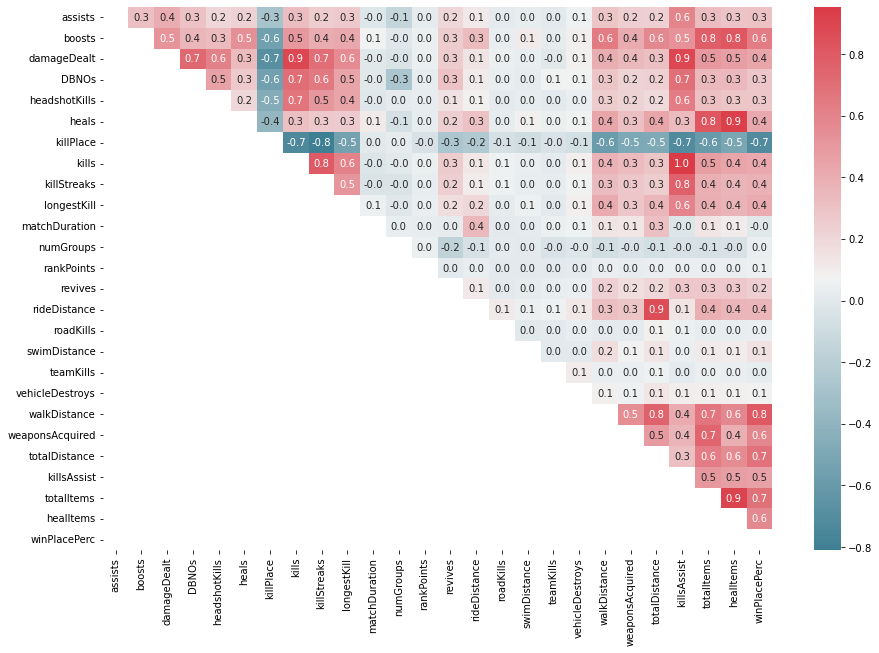

In [25]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
fig, ax = plt.subplots(figsize = (15, 10))
corrMatrix = finalDF.corr()
sns.heatmap(corrMatrix, ax=ax, annot=True, fmt=".1f", cmap=cmap,
            mask=np.tril(np.ones_like(corrMatrix, dtype=bool)))

**Correlation with winPlacePerc:** <br/>

1. There is strong correlation between `winPlacePerc` and `weaponsAcquired`, `winPoints`, and `boosts`. A positive correlation means that an increase in each of these attributes is associated with an increase in `winPlacePerc` (the relationship is not 1 to 1, each has a different strength of the relationship). <br/>

2. A strong negative correlation exists between `winPlacePerc` and `killPlace`. This tells us that a low `killPlace` (lower is better) is associated with a high `winPlacePerc` (higher is better), which makes sense, a player with a better `killPlace` would rank better. <br/>

The strong correlation between these attributes and `winPlacePerc` (driver of our target variable = `quart_binary`) tells us that these are likely the ones that have the most influence on the `winPlacePerc` attribute, and should be included in our final model. 

**Additional observations** (related to the attributes strongly correlated with `winPlacePerc`: `weaponsAcquired`, `winPoints`, `boosts`, and `killPlace`):
1. The `weaponsAcquired` feature does not appear to have a high correlation with any other attributes.
2. There's a strong correlation between `winPoints` and `killPoints`.
3. A strong correlation exists between `boosts` and `walkDistance` and a strong negative correlation between `boosts` and `killPlace`.
4. Another strong negative correlation can be found between `killPoints` and `kills`, `killStreaks`, and `walkDistance`.

**Additional observations** (misc):
1. We find high negative correlation between `rankPoints` and `killPoints`.
2. There's high negative correlation between `rankPoints` and `winPoints`. 

### walkDistance, headshotKills, and winPlacePerc

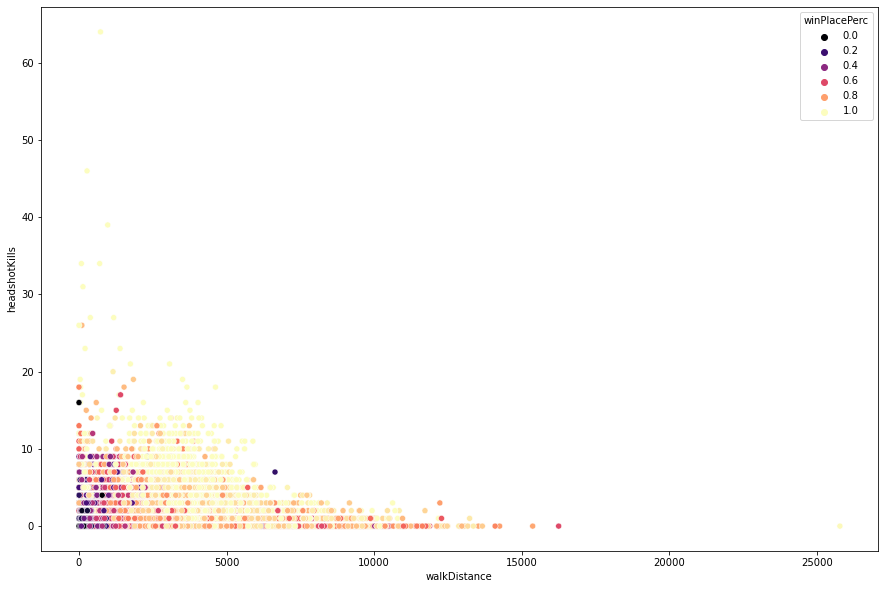

In [26]:
plt.figure(figsize = (15, 10))
sns.scatterplot(data = finalDF, x="walkDistance", y="headshotKills",
                hue="winPlacePerc", sizes=(20, 200), palette="magma")
plt.show()

Distance walked has the highest correlation with `winPlacePerc`. This makes sense, because if a player stays alive longer, they likely also walk a greater distance than players that do not survive for very long. Additionally, these players (that stay alive longer and walk greater distance) also are likely place higher. 

# **MODELING AND EVALUATION SECTIONS SUMMARY** #
*Assignment (from course overview document): Different tasks will require different evaluation methods. Be as thorough as possible when analyzing the data you have chosen and use visualizations of the results to explain the performance and expected outcomes whenever possible.* <br/>

Option A: Cluster Analysis
* ***Train:** Perform cluster analysis using several clustering methods (adjust parameters).* <br/>
* ***Eval:** Use internal and/or external validation measures to describe and compare the clusterings and the clusters— how did you determine a suitable number of clusters for each method?* <br/>
* ***Visualize:** Use tables/visualization to discuss the found results. Explain each visualization in detail.* <br/>
* ***Summarize:** Describe your results. What findings are the most interesting and why?* <br/>

**We will need to organize content to include MORE THAN 1    cluster approaches in multiple sections.** <br/>
Need to have all sections for each cluster approach: (1) TRAIN, (2) EVAL, (3) VISUALIZE, (4) SUMMARIZE.

<a id='ME1'></a>

# **MODELING AND EVALUATION 1**

Jump to [Top](#TOP)

*Assignment: Train and adjust parameters.*

## TRAIN-TEST SPLIT

In [27]:
# TRAIN-TEST-SPLIT-0
# reference: https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn

train_ratio = 0.70
validation_ratio = 0.20
test_ratio = 0.10

# creation of feature-space and response-vectors
dataX = finalDF.loc[:, cols_df]
dataY = finalDF.loc[:, ('winPlacePerc','quart_binary')]

# train is now 70% of the entire data set
x_train, x_test, y_train, y_test = train_test_split(dataX, dataY, test_size=(1-train_ratio), random_state=17)

# test is now 10% of the initial data set
# validation is now 20% of the initial data set 
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test,
                                                test_size=test_ratio/(test_ratio + validation_ratio), random_state=117) 

print("Training Data shape:   ", x_train.shape)
print("Validating Data shape: ", x_val.shape)
print("Test Data shape:       ", x_test.shape)

Training Data shape:    (1921608, 25)
Validating Data shape:  (549031, 25)
Test Data shape:        (274516, 25)


In [28]:
# TRAIN-TEST-SPLIT-1
# look at VALIDATE data to confirm that the train-test-split has randomized the data order

print("Evaluation of Index Selection\nHead:\n",x_val.head().index,
      "\nTail:\n",x_val.tail().index)

# confirmed = test_train_split has randomized the data order

Evaluation of Index Selection
Head:
 Int64Index([1764352, 83992, 965563, 1672690, 3041784], dtype='int64') 
Tail:
 Int64Index([3198970, 1694316, 2366209, 1797295, 1310957], dtype='int64')


In [29]:
# TRAIN-TEST-SPLIT-2
# create TUNE data (x_tune, y_tune) = subset of TRAIN 
indices = x_train.sample(n=50000, replace=False, random_state=17).index
x_tune = x_train.loc[indices, :]
y_tune = y_train.loc[indices, :]

print("Tuning Data shape: ", x_tune.shape)
print(dataY[dataY.quart_binary=='1'].shape)
print(dataY[dataY.quart_binary=='0'].shape)
print(y_tune[y_tune.quart_binary=='1'].shape)
print(y_tune[y_tune.quart_binary=='0'].shape)

Tuning Data shape:  (50000, 25)
(697494, 2)
(2047661, 2)
(12653, 2)
(37347, 2)


<div class="alert alert-block alert-info">
<b><h3>Please Consider the "Exploratory Analysis" below as a continuation of Data Understanding 2</h3>
    </b>
</div>

### KMEANS CLUSTERS: EXPLORATORY ANALYSIS

Jump to [Top](#TOP)

Note: We will use Random Forest as our classification model type.

### K-means baseline model (Random Forest classifier)

Build RF Classifier model to use as our baseline (to compare with models we build using cluster-variables).

In [30]:
# reference: ML Notebook 9: Clustering and Discretization
# updated 03-30-22 - to run this using SUBSET OF DATA = JUST USE TUNE

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

X = x_tune.loc[:, cols_df]
y = y_tune.loc[:, ('quart_binary')]
cv = StratifiedKFold(n_splits=10)

clf = RandomForestClassifier(n_estimators=150, random_state=17)

acc = cross_val_score(clf, X=X, y=y, cv=cv)

print ("Baseline average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

Baseline average accuracy =  91.916 +- 0.27782008566696637


### K-means clusters: Ride distance with walk distance

#### Plot: rideDistance + walkDistance

*Reference: notebook 09* <br/>
Okay, now let's start with a bit of feature engineering. We will start by using kmeans on `rideDistance` and `walkDistance` together.

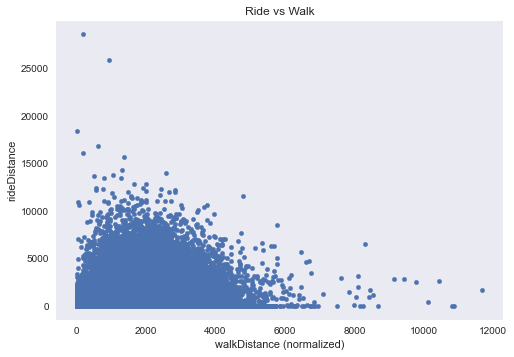

In [31]:
# reference: notebook 09
from matplotlib import pyplot as plt
# changed this from "ggplot" to "seaborn"
plt.style.use("seaborn") 

# reference: another type of style = "fivethirtyeight" 
# plt.style.use("fivethirtyeight") 

# %matplotlib inline
x_ride_walk = x_tune[['rideDistance','walkDistance']].values

plt.scatter(x_ride_walk[:, 1], x_ride_walk[:, 0]+np.random.random(x_ride_walk[:, 1].shape)/2, 
             s=20)
plt.xlabel('walkDistance (normalized)'), plt.ylabel('rideDistance')
plt.grid()
plt.title('Ride vs Walk')
plt.show()

There doesn't appear to be a strong correlation between `rideDistance` and `walkDistance`. Not sure this would be very useful.

#### Accuracy: rideDistance + walkDistance

In [32]:
# reference: notebook 09

from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

x_ride_walk = x_tune[['rideDistance','walkDistance']]

cls = KMeans(n_clusters=8, init='k-means++',random_state=17)
cls.fit(x_ride_walk)
newfeature = cls.labels_ # the labels from kmeans clustering

cv_ride_walk = StratifiedKFold(n_splits=10)

x_ride_walk = x_tune.loc[:, cols_df]
y_ride_walk = y_tune.loc[:, ('quart_binary')]
x_ride_walk = np.column_stack((x_ride_walk,pd.get_dummies(newfeature)))

acc_ride_walk = cross_val_score(clf,x_ride_walk,y=y_ride_walk,cv=cv_ride_walk)

print ("Average accuracy (with kmeans for ride/walkDistance)= ", acc_ride_walk.mean()*100, "+-", acc_ride_walk.std()*100)

Average accuracy (with kmeans for ride/walkDistance)=  91.82400000000001 +- 0.29445542956447535


It does not look like this first pass at clusters has any positive impact on our performance. Accuracy did not improve (actually went down slightly), standard deviation did not go down (it went up just a bit). 

For reference: baseline model has accuracy 91.916 +- 0.27782. 

Next, we took a look at the data shapes in the above section (Evaluate outliers), to see if there are any attributes that might be good for clusters. <br/>

It looks like `matchDuration` has a couple groupings. It also looks like `numGroups` has 3 clusters. <br/>
Let's take a look at them. <br/>

### K-means clusters: Match duration with walk distance

#### Plot: matchDuration + walkDistance

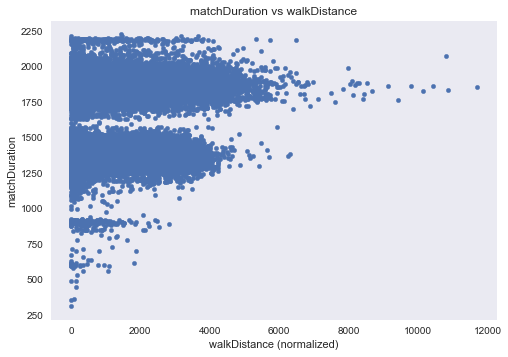

In [33]:
# reference: notebook 09
# from matplotlib import pyplot as plt
# plt.style.use("seaborn")

# %matplotlib inline
x_match_walk = x_tune[['matchDuration','walkDistance']].values

plt.scatter(x_match_walk[:, 1], x_match_walk[:, 0]+np.random.random(x_match_walk[:, 1].shape)/2, 
             s=20)
plt.xlabel('walkDistance (normalized)'), plt.ylabel('matchDuration')
plt.grid()
plt.title('matchDuration vs walkDistance')
plt.show()

Boo yah! It looks like we have about 3 'clusters' when we look at `matchDuration` vs. `walkDistance`! <br/>

What does it look like when use matchDuration with our new feature = `totalDistance`?

### K-means clusters: Match duration with total distance

#### Plot: matchDuration + totalDistance

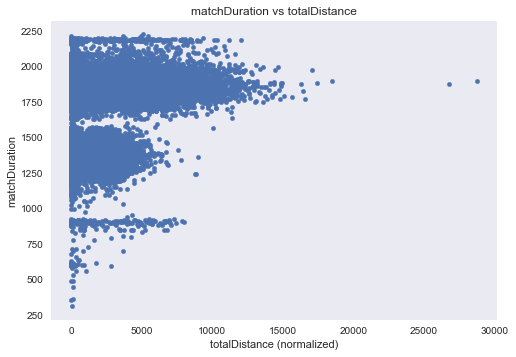

In [34]:
# reference: notebook 09
# from matplotlib import pyplot as plt
# plt.style.use("seaborn")

# %matplotlib inline
x_match_total = x_tune[['matchDuration','totalDistance']].values

plt.scatter(x_match_total[:, 1], x_match_total[:, 0]+np.random.random(x_match_total[:, 1].shape)/2, 
             s=20)
plt.xlabel('totalDistance (normalized)'), plt.ylabel('matchDuration')
plt.grid()
plt.title('matchDuration vs totalDistance')
plt.show()

`totalDistance` also looks to have 3 clusters, not totally sure if it is 'better' than the `walkDistance`. At a glance, `walkDistance` appears to be a bit more tightly clustered. Let's try to run the model for both and see if we have any difference.

### K-means clusters: Match duration with walk distance

#### Accuracy: matchDuration + walkDistance

In [35]:
# AVERAGE ACCURACY FOR MATCH-DURATION + WALK-DISTANCE
# reference: notebook 09

from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

x_match_walk = x_tune[['matchDuration','walkDistance']]

cls_match_walk = KMeans(n_clusters=8, init='k-means++',random_state=17)
cls_match_walk.fit(x_match_walk)
newfeature_match_walk = cls_match_walk.labels_ # the labels from kmeans clustering

cv_match_walk = StratifiedKFold(n_splits=10)

x_match_walk = x_tune.loc[:, cols_df]
y_match_walk = y_tune.loc[:, ('quart_binary')]
x_match_walk = np.column_stack((x_match_walk,pd.get_dummies(newfeature_match_walk)))

acc_match_walk = cross_val_score(clf,x_match_walk,y=y_match_walk,cv=cv_match_walk)

print ("Average accuracy (with kmeans for matchDuration/walkDistance)= ", acc_match_walk.mean()*100, "+-", acc_match_walk.std()*100)

Average accuracy (with kmeans for matchDuration/walkDistance)=  91.77799999999999 +- 0.3699135034031609


Well, it does not appear that the cluster dummy variables for (`matchDuration` + `walkDistance`) is much help either. 

### K-means clusters: Match duration with total distance

#### Accuracy: matchDuration + totalDistance

In [36]:
# MATCH DURATION + TOTAL DISTANCE 
# from sklearn.cluster import KMeans
# import numpy as np
# import pandas as pd

x_match_total = x_tune[['matchDuration','totalDistance']]

cls_match_total = KMeans(n_clusters=8, init='k-means++',random_state=17)
cls_match_total.fit(x_match_total)
newfeature_match_total = cls_match_total.labels_ # the labels from kmeans clustering

cv_match_total = StratifiedKFold(n_splits=10)

x_match_total = x_tune.loc[:, cols_df]
y_match_total = y_tune.loc[:, ('quart_binary')]
x_match_total = np.column_stack((x_match_total,pd.get_dummies(newfeature_match_total)))

acc_match_total = cross_val_score(clf,x_match_total,y=y_match_total,cv=cv_match_total)

print ("Average accuracy (with kmeans for matchDuration/totalDistance)= ", acc_match_total.mean()*100, "+-", acc_match_total.std()*100)


Average accuracy (with kmeans for matchDuration/totalDistance)=  91.83800000000002 +- 0.28403520908506996


**Slight improvement with this model.**

Looks like this version is still very slightly worse than the baseline model; the accuracy is just under, and the standard deviation has gone up ever-so-slightly. 

For reference: baseline model has accuracy 91.916 +- 0.27782. 

### K-means clusters: Total items with total distance

#### Accuracy: totalItems + totalDistance

In [37]:
# TOTAL ITEMS + TOTAL DISTANCE 
# from sklearn.cluster import KMeans
# import numpy as np
# import pandas as pd

x_items_distance = x_tune[['totalItems','totalDistance']]

cls_items_distance = KMeans(n_clusters=8, init='k-means++',random_state=17)
cls_items_distance.fit(x_items_distance)
newfeature_items_distance = cls_items_distance.labels_ # the labels from kmeans clustering

cv_items_distance = StratifiedKFold(n_splits=10)

x_items_distance = x_tune.loc[:, cols_df]
y_items_distance = y_tune.loc[:, ('quart_binary')]
x_items_distance = np.column_stack((x_items_distance,pd.get_dummies(newfeature_items_distance)))

acc_items_distance = cross_val_score(clf,x_items_distance,y=y_items_distance,cv=cv_items_distance)

print ("Average accuracy (with kmeans for totalItems/totalDistance)= ", acc_items_distance.mean()*100, "+-", acc_items_distance.std()*100)


Average accuracy (with kmeans for totalItems/totalDistance)=  91.856 +- 0.33380233672040255


Looks like this version is not as good as the baseline model when including dummy variables with clusters on `totalItems` and `totalDistance`.

For reference: baseline model has accuracy 91.916 +- 0.27782. 


### K-means clusters: Heal items with kills assist

#### Accuracy: healItems + killsAssist

In [38]:
# HEAL ITEMS + KILLS ASSISST  
# from sklearn.cluster import KMeans
# import numpy as np
# import pandas as pd

x_heal_kill = x_tune[['healItems','killsAssist']]

cls_heal_kill = KMeans(n_clusters=8, init='k-means++',random_state=17)
cls_heal_kill.fit(x_heal_kill)
newfeature_heal_kill = cls_heal_kill.labels_ # the labels from kmeans clustering

cv_heal_kill = StratifiedKFold(n_splits=10)

x_heal_kill = x_tune.loc[:, cols_df]
y_heal_kill = y_tune.loc[:, ('quart_binary')]
x_heal_kill = np.column_stack((x_heal_kill,pd.get_dummies(newfeature_heal_kill)))

acc_heal_kill = cross_val_score(clf,x_heal_kill,y=y_heal_kill,cv=cv_heal_kill)

print ("Average accuracy (with kmeans for healItems/killsAssist)= ", acc_heal_kill.mean()*100, "+-", acc_heal_kill.std()*100)


Average accuracy (with kmeans for healItems/killsAssist)=  91.816 +- 0.2637877935007584


Baseline average accuracy =  91.916 +- 0.27782.

The main take-away is that we don't see any particular benefits from clustering for our prediction analysis. We don't particularly improve Accuracy or Standard Deviation.

This has been a partially informed analysis from what we believe would make sense to cluster on after looking at the attributes/features in the data.

### Scale data to prep for PCA & Hierarchical

Because we haven't been able to improve the prediction capabilities on raw data, we'll attempt PCA in order to make our clustering as well-informed as possible.

First, create copy of DF and scale the data. <br/>
We will scale the data to have a mean of 0 and standard deviation of 1. <br/>
We want to scale the data before doing PCA. Scaling the data tells PCA that all the attributes are of equal importance. 

In [39]:
# Scale data

# define scaler
scaler = StandardScaler()

# create copy of dataframe to scale for PCA
scaled_x_tune = x_tune.copy()

# create scaled version of data frame 
scaled_x_tune = pd.DataFrame(scaler.fit_transform(scaled_x_tune), columns = scaled_x_tune.columns)

# reference: https://www.statology.org/scree-plot-python/

# confirm we have removed matchType (can delete this later)
# cols_df_tune = scaled_x_tune.columns.values.tolist()
# cols_df_tune

In [40]:
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
import sklearn.metrics as sm

random.seed(10)

Create new DF for our clustering efforts = sample 2,000 records from x_tune.

In [41]:
y_tune_df = pd.DataFrame(y_tune, columns=y_tune.columns)
y_tune_df = y_tune_df.reset_index(drop=False)

indices_slim = scaled_x_tune.sample(n=2000, replace=False, random_state=17).index
x_tune_slim = scaled_x_tune.loc[indices_slim, :]
y_tune_slim = y_tune_df.loc[indices_slim, :]

Hierarchical clustering is an algorithm that groups similar objects into groups called clusters. Simply, it forms as many clusters as there are data points then take two nearest data points and make them a cluster. Then take two nearest clusters and make them a cluster and repeat this step until there is only one finaly cluster.

Dendrogram shows the hierarchical relationship between the clusters as we show for our x_tune_slim.

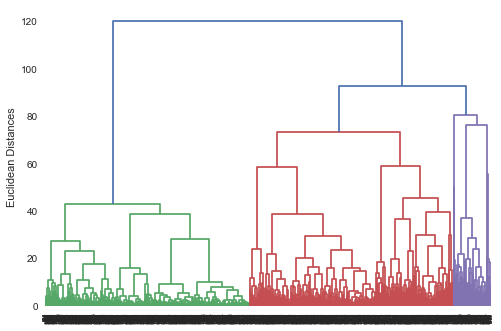

In [42]:
# Visulaizations
dendrogram = sch.dendrogram(sch.linkage(x_tune_slim, method = 'ward'))
plt.ylabel('Euclidean Distances')
plt.show()

Although, we could potentially define the best clusters using the dendrogram, it is a better practice to find the accuracy of mean and standard deviation to determine which is a better distance meterics, linkage, and number of clusters for the model.

There are other types of distance metrics could be used but we decided to use Euclidean and Cosine distance and for linkage criteria, we looked at ward, complete, and average. We had to consider that if linkage is ward, only Euclidean is accpected.

The best model would be with a high accuracy and a low standard deviation. However, it is difficult identify which model is the best so we calculated a difference for each algorithm to determine the best possible model.

Let's reassess and do some PCA before we try clusters again.

# **Modeling and Evaluation 1 (cont.)**

*Assignment: Train and adjust parameters.*

## PCA FOR CLUSTERS

Jump to [Top](#TOP)

*Why do we do PCA before clustering?*

In short, we perform PCA for **dimensionality reduction**.

Clustering is highly sensitive to dimensionality, it is also hard to visualize outside of 3-Dimensions. We will use PCA to reduce the dimensionality of the data before we try clustering again. 

*reference: https://www.kaggle.com/code/robroseknows/pubg-clustering-exploration/notebook* 


It is necessary to **normalize** data before performing PCA. The PCA calculates a new projection of your data set. And the new axis are based on the standard deviation of your variables. <br/>

*reference: https://www.researchgate.net/post/Is-it-necessary-to-normalize-data-before-performing-principle-component-analysis#:~:text=Yes%2C%20it%20is%20necessary%20to,standard%20deviation%20of%20your%20variables*

#### Perform PCA on scaled_x_tune

In [43]:
# import library
from sklearn.decomposition import PCA

# define PCA model to use (start with 14 = random number)
pca14 = PCA(n_components = 14)

# fit PCA model to data (scaled_x_tune)
pca14_fit = pca14.fit(scaled_x_tune)
P14 = pca14.transform(scaled_x_tune)

In [44]:
# how much of the variance is explained by 14 components
print(sum(pca14.explained_variance_ratio_))

# reference: https://www.kaggle.com/code/robroseknows/pubg-clustering-exploration/notebook

0.910351412370801


This tells us that about 91% of the variance in x_tune can be explained using 14 components. <br/>

Let's look at the breakdown of % variance explained by each principal component.

In [45]:
print(pca14.explained_variance_ratio_ * 100)

[34.350872  11.092523   5.4613895  4.959305   4.2574177  4.1059637
  4.072749   3.9200096  3.6937654  3.5024033  3.2831855  3.1688287
  2.8406036  2.3261254]


This tells us that: <br/>
* The first principal component explains 34.3% of the total variance in the scaled_x_tune dataset. <br/>
* The second principal component explains an additional 11.1% of the total variance in the scaled_x_tune dataset. <br/>
* The third principal component explains an additional 5.5% of the total variance in the scaled_x_tune dataset. <br/>
* The fourth principal component explains an additional 4.9% of the total variance in the scaled_x_tune dataset. <br/>
* And so on.

#### PCA Scree plot

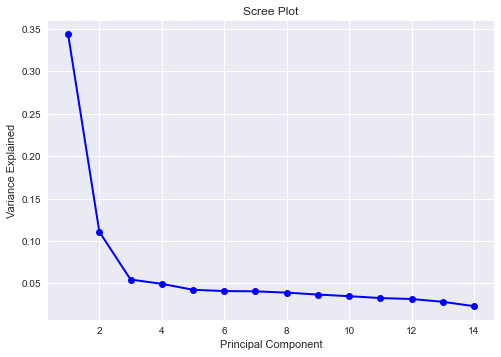

In [46]:
# SCREE PLOT for PCA (pca on x_tune)
# Visualize eigenvalues/variances

# import matplotlib.pyplot as plt
# import numpy as np

PC_values = np.arange(pca14.n_components_) + 1
plt.plot(PC_values, pca14.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

*reference: https://www.kaggle.com/code/robroseknows/pubg-clustering-exploration/notebook* <br/>
*reference: https://www.statology.org/scree-plot-python/* <br/>

The bend in the elbow of the scree plot (above) is a good indicator for how many eigenvectors to use. Here we see it happens at component 3 or 4, meaning 3 components are sufficient to explain the most variance with the most parsimonious model. Therefore, we'll proceed with cluster analysis with 3 principal components.

In [47]:
# check variance explained by 3 components (using scaled_x_tune)

# define PCA model to use (3)
pca3 = PCA(n_components=3)

# fit PCA model to data
pca3_fit = pca3.fit(scaled_x_tune)

# how much of the variance is explained by 3 components
print(sum(pca3.explained_variance_ratio_))

# store the principal components in variable
P3 = pca3.transform(scaled_x_tune)

# reference: https://www.kaggle.com/code/robroseknows/pubg-clustering-exploration/notebook
# reference: https://medium.com/more-python-less-problems/principal-component-analysis-and-k-means-clustering-to-visualize-a-high-dimensional-dataset-577b2a7a5fe2

0.5090363398194313


Looks like around 51% of the variance in the data can be explained by using 3 components. <br/>
We will use this data (scaled, PCA = 3) to build our clusters. <br/>

Now we will plot the first 2 components to see if there are any clear clusters that jump out.

*reference: https://medium.com/more-python-less-problems/principal-component-analysis-and-k-means-clustering-to-visualize-a-high-dimensional-dataset-577b2a7a5fe2*

Text(0, 0.5, 'PCA 2')

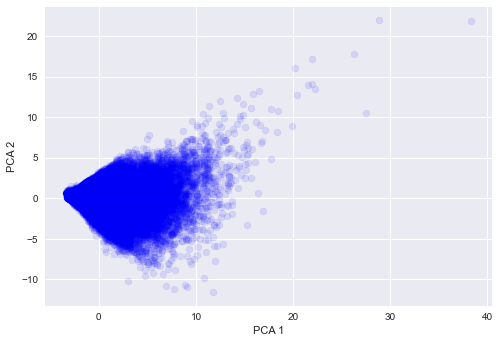

In [48]:
# store the principal components (3) into pca3_comp_stg object
pca3_comp_stg = pca3.fit_transform(scaled_x_tune)

# save components to dataFrame
pca3_comp = pd.DataFrame(pca3_comp_stg)

# plot the components to see if we can find clusters
plt.scatter(pca3_comp[0], pca3_comp[1], alpha = 0.1, color = 'blue')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

There is no readily visible grouping to help a human understand separation within the data. We'll continue by trying 3-dimensional visualization.

#### PCA 3D plot

C:\Users\sherm\AppData\Local\Temp/ipykernel_22772/1455752897.py:5: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig_p3, elev=17, azim=75)
C:\Users\sherm\AppData\Local\Temp/ipykernel_22772/1455752897.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_p3.show()


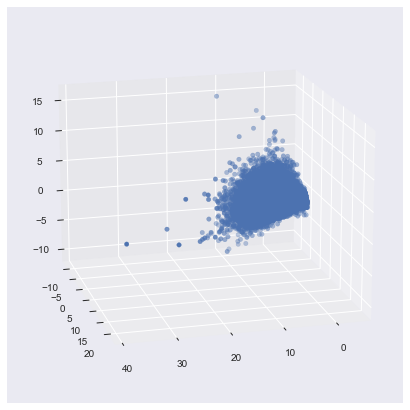

In [49]:
# plot first 3 componenets - using first 100,000 records
from mpl_toolkits.mplot3d import Axes3D
fig_p3 = plt.figure()
# ax = Axes3D(fig_p3, elev=48, azim=134) # original
ax = Axes3D(fig_p3, elev=17, azim=75)
ax.scatter(P3[:100000, 0], P3[:100000, 1], P3[:100000, 2])
fig_p3.show()

# # rotate the axes and update
# for angle in range(0, 360):
#     ax.view_init(50, angle)
#     plt.draw()
#     plt.pause(.001)

This does not really look like we are finding the "clusters" we expect.

Now that we have reduced dimensionality of the data using PCA, we can do some clusters and see if they helped. 

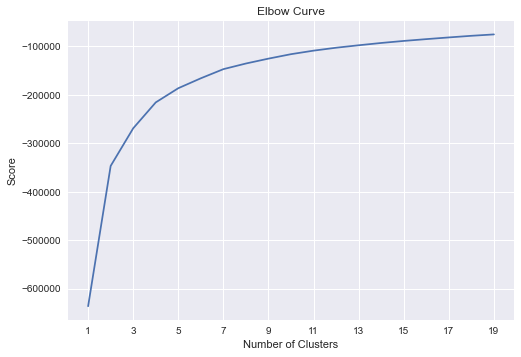

In [50]:
n_clusters = range(1, 20)
kmeans = [KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, tol=0.0001,
                 verbose=0, random_state=None, copy_x=True) 
          for i in n_clusters]
score = [kmeans[i].fit(P3).score(P3) for i in range(len(kmeans))]
plt.plot(n_clusters,score)
plt.xticks([1,3,5,7,9,11,13,15,17,19], [1,3,5,7,9,11,13,15,17,19])
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

Visually speaking, we may have reached a plateau in improvement by 13 clusters. We'll proceed under that assumption.

FIT NEW MODEL WITH 13 CLUSTERS + CHECK PERFORMANCE

In [51]:
# start with clusters = 13
kms = KMeans(n_clusters=13).fit(P3)

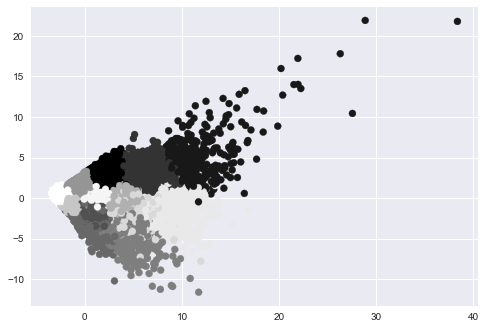

In [52]:
plt.style.use("seaborn")
plt.scatter(P3[:100000, 0], P3[:100000, 1], c=kms.labels_[:100000])
plt.show()

Again, these are not human-discernible.

In [53]:
# store our first 3 principal components in dataFrame
column_names = ['pc_0','pc_1','pc_2']
pca3_slim = pd.DataFrame(P3, columns = column_names)

pca3_slim.head()

,pc_0,pc_1,pc_2
0,-1.006365,1.738836,0.291727
1,-0.747356,1.102793,0.418179
2,-1.493516,0.264003,-1.372072
3,-1.054105,-1.479501,1.299936
4,3.697082,-0.811916,-2.419552


In [54]:
# NEED TO PULL SAMPLE OF 2000 FOR PCA3_SLIM TO MATCH SCALED_X_TUNE

x_pca_slim = pca3_slim.loc[indices_slim, :]

Test accuracy with added features = clusters from first 3 principal components.

In [55]:
# PCA
# this code will add new features to represent PCs 1, 2, 3
# IN ADDITION TO the other features in cols_df

# pca3_slim

# X1 = df_imputed[['Pclass','Fare']]
# X2 = df_imputed[['Age','Parch','SibSp']]

params = []

# we will vary parameters on match-total with # clusters 4 - 9
for i in range(4,9):
   # for x_heal in range(3,8):
        # get the first clustering
        cls_p3 = KMeans(n_clusters=i, init='k-means++',random_state=17)
        cls_p3.fit(x_pca_slim)
        newfeature_p3 = cls_p3.labels_ # the labels from kmeans clustering

        # # # append on the second clustering
        # cls_heal_kill = KMeans(n_clusters=x_heal, init='k-means++',random_state=17)
        # cls_heal_kill.fit(x_heal_kill)
        # newfeature_heal_kill = cls_heal_kill.labels_ # the labels from kmeans clustering

        y = y_tune_slim.loc[:, ('quart_binary')]
        X = x_pca_slim
        # X = np.column_stack((X,pd.get_dummies(newfeature_match_total)))
        X = np.column_stack((X,pd.get_dummies(newfeature_p3)))

        acc = cross_val_score(clf,X,y=y,cv=cv)
        # params.append((x_match,acc.mean()*100,acc.std()*100)) # save state
        params.append((i,acc.mean()*100,acc.std()*100)) # save state

        # print ("Clusters",x_match,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)
        print ("Clusters",i,"Average accuracy: PCA 3 WITH other attributes = ", acc.mean()*100, "+-", acc.std()*100)

# reference: 09.Clustering and discretization.ipynb

Clusters 4 Average accuracy: PCA 3 WITH other attributes =  83.0 +- 2.3345235059857496
Clusters 5 Average accuracy: PCA 3 WITH other attributes =  83.65 +- 2.7843311584651707
Clusters 6 Average accuracy: PCA 3 WITH other attributes =  83.65 +- 2.3774986855937477
Clusters 7 Average accuracy: PCA 3 WITH other attributes =  83.39999999999999 +- 2.385372088375312
Clusters 8 Average accuracy: PCA 3 WITH other attributes =  83.55 +- 2.161596632121728


Test accuracy with ONLY clusters from first 3 principal components.

In [56]:
# pca3_comp[0], pca3_comp[1],
# pca3_slim

# X1 = df_imputed[['Pclass','Fare']]
# X2 = df_imputed[['Age','Parch','SibSp']]

params = []

# we will vary parameters on match-total with # clusters 4 - 9
for i in range(4,9):
   # for x_heal in range(3,8):
        # get the first clustering
        cls_p3 = KMeans(n_clusters=i, init='k-means++',random_state=17)
        cls_p3.fit(x_pca_slim)
        newfeature_p3 = cls_p3.labels_ # the labels from kmeans clustering

        # # # append on the second clustering
        # cls_heal_kill = KMeans(n_clusters=x_heal, init='k-means++',random_state=17)
        # cls_heal_kill.fit(x_heal_kill)
        # newfeature_heal_kill = cls_heal_kill.labels_ # the labels from kmeans clustering

        y = y_tune_slim.loc[:, ('quart_binary')]
        X = pd.get_dummies(newfeature_p3)
        
        # X = np.column_stack((X,pd.get_dummies(newfeature_p3)))

        acc = cross_val_score(clf,X,y=y,cv=cv)
        # params.append((x_match,acc.mean()*100,acc.std()*100)) # save state
        params.append((i,acc.mean()*100,acc.std()*100)) # save state

        # print ("Clusters",x_match,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)
        print ("Clusters",i,"Average accuracy: PCA 3 WITHOUT other attributes = ", acc.mean()*100, "+-", acc.std()*100)

# reference: 09.Clustering and discretization.ipynb

Clusters 4 Average accuracy: PCA 3 WITHOUT other attributes =  84.5 +- 2.3130067012440754
Clusters 5 Average accuracy: PCA 3 WITHOUT other attributes =  83.85000000000001 +- 1.8309833423600548
Clusters 6 Average accuracy: PCA 3 WITHOUT other attributes =  83.10000000000001 +- 3.088689042296098
Clusters 7 Average accuracy: PCA 3 WITHOUT other attributes =  81.89999999999999 +- 2.199999999999998
Clusters 8 Average accuracy: PCA 3 WITHOUT other attributes =  81.80000000000001 +- 1.8601075237738247


Let's vary the parameters of our KMEANS clusters to see what works.

### Tune Parameters for KMeans - Number of Clusters

Jump to [Top](#TOP)

In [57]:
x_match_total = x_tune_slim[['matchDuration','totalDistance']]
x_heal_kill = x_tune_slim[['healItems','killsAssist']]

# X1 = df_imputed[['Pclass','Fare']]
# X2 = df_imputed[['Age','Parch','SibSp']]

params = []

# we will vary parameters on match-total with # clusters 4 - 14
for x_match in range(4,15):
   # for x_heal in range(16,19):
        # get the first clustering
        cls_match_total = KMeans(n_clusters=x_match, init='k-means++',random_state=17)
        cls_match_total.fit(x_match_total)
        newfeature_match_total = cls_match_total.labels_ # the labels from kmeans clustering

        # # append on the second clustering
        # cls_heal_kill = KMeans(n_clusters=x_heal, init='k-means++',random_state=17)
        # cls_heal_kill.fit(x_heal_kill)
        # newfeature_heal_kill = cls_heal_kill.labels_ # the labels from kmeans clustering

        y = y_tune_slim.loc[:, ('quart_binary')]
        X = x_tune_slim.loc[:, cols_df]
        X = np.column_stack((X,pd.get_dummies(newfeature_match_total)))
        # X = np.column_stack((X,pd.get_dummies(newfeature_match_total),pd.get_dummies(newfeature_heal_kill)))

        acc = cross_val_score(clf,X,y=y,cv=cv)
        params.append((x_match,acc.mean()*100,acc.std()*100)) # save state
        # params.append((x_match,x_heal,acc.mean()*100,acc.std()*100)) # save state

        print ("Clusters",x_match,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)
        # print ("Clusters",x_match,x_heal,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

# reference: 09.Clustering and discretization.ipynb

Clusters 4 Average accuracy =  91.4 +- 1.624807680927191
Clusters 5 Average accuracy =  90.9 +- 1.593737745050924
Clusters 6 Average accuracy =  90.95 +- 1.863464515358422
Clusters 7 Average accuracy =  91.25 +- 1.8200274723201288
Clusters 8 Average accuracy =  91.19999999999999 +- 1.9131126469708972
Clusters 9 Average accuracy =  90.85000000000001 +- 1.8980252896102299
Clusters 10 Average accuracy =  90.75000000000001 +- 2.0766559657295183
Clusters 11 Average accuracy =  90.75 +- 2.0031225624010123
Clusters 12 Average accuracy =  90.95 +- 1.849999999999998
Clusters 13 Average accuracy =  90.75000000000001 +- 1.7066048165876004
Clusters 14 Average accuracy =  90.64999999999999 +- 2.1336588293351872


It seems that about the best we can do with these new discretization methods is around 91.3%. All the models are within one standard deviation of each other, so most clustering in this range are pretty reasonable.

Next, let's capture accuracy & standard deviation when we combine 2 clusters. <br/>
We will adjust the number of clusters for `matchDuration`/`totalDistance` and `healItems`/`killsAssist` and see what performance looks like.

**Cluster definitions:** <br/>
1. Cluster 1 (`match_total`): Builds additional attributes from clusters on `matchDuration`/`totalDistance` <br/>
2. Cluster 2 (`heal_kill`): Builds additional attributes from clusters on `healItems`/`killsAssist` <br/>

The loop below builds a model that includes **both** clusterings, and returns the average accuracy score (from cross validation), and the average standard deviation for every cluster-count combination of the 2 groupings (Cluster 1, Cluster 2). <br/>

In [58]:
x_match_total = x_tune_slim[['matchDuration','totalDistance']]
x_heal_kill = x_tune_slim[['healItems','killsAssist']]
x_items_distance = x_tune_slim[['totalItems','totalDistance']]

# X1 = df_imputed[['Pclass','Fare']]
# X2 = df_imputed[['Age','Parch','SibSp']]

params_k = []

# we will vary parameters on match-total with # clusters 4 - 9
for x_match in range(4,9):
   for x_heal in range(3,8):
        # get the first clustering
        cls_match_total = KMeans(n_clusters=x_match, init='k-means++',random_state=17)
        cls_match_total.fit(x_match_total)
        newfeature_match_total = cls_match_total.labels_ # the labels from kmeans clustering

        # # append on the second clustering
        cls_heal_kill = KMeans(n_clusters=x_heal, init='k-means++',random_state=17)
        cls_heal_kill.fit(x_heal_kill)
        newfeature_heal_kill = cls_heal_kill.labels_ # the labels from kmeans clustering

        y = y_tune_slim.loc[:, ('quart_binary')]
        X = x_tune_slim.loc[:, cols_df]
        # X = np.column_stack((X,pd.get_dummies(newfeature_match_total)))
        X = np.column_stack((X,pd.get_dummies(newfeature_match_total),pd.get_dummies(newfeature_heal_kill)))

        acc = cross_val_score(clf,X,y=y,cv=cv)
        # params.append((x_match,acc.mean()*100,acc.std()*100)) # save state
        params_k.append((x_match,x_heal,acc.mean()*100,acc.std()*100)) # save state

        # print ("Clusters",x_match,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)
        print ("Clusters",x_match,x_heal,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

# reference: 09.Clustering and discretization.ipynb

Clusters 4 3 Average accuracy =  91.39999999999999 +- 1.496662954709575
Clusters 4 4 Average accuracy =  91.10000000000001 +- 1.5132745950421544
Clusters 4 5 Average accuracy =  91.25 +- 1.6007810593582112
Clusters 4 6 Average accuracy =  91.05000000000001 +- 1.6039014932345428
Clusters 4 7 Average accuracy =  91.05000000000001 +- 1.6499999999999995
Clusters 5 3 Average accuracy =  91.05000000000001 +- 1.4908051515875564
Clusters 5 4 Average accuracy =  91.20000000000002 +- 1.5198684153570656
Clusters 5 5 Average accuracy =  91.1 +- 1.5620499351813322
Clusters 5 6 Average accuracy =  90.9 +- 1.8275666882497057
Clusters 5 7 Average accuracy =  90.85000000000001 +- 1.7755280904564699
Clusters 6 3 Average accuracy =  90.9 +- 1.8275666882497057
Clusters 6 4 Average accuracy =  91.05000000000001 +- 1.916376789673679
Clusters 6 5 Average accuracy =  90.7 +- 1.5524174696260016
Clusters 6 6 Average accuracy =  90.7 +- 1.661324772583614
Clusters 6 7 Average accuracy =  91.05000000000001 +- 1.64

Creating multiple clustering scenarios doesn't produce apparent benefit. These clusters are slightly tighter in terms of accuracy results. We appear to have two peaks in accuracy—one low at 4 & 3 clusters and one high at 7 & 3 clusters.

### AGGLOMERATIVE CLUSTERS

Jump to [Top](#TOP)

In [59]:
params = []
difference = 100

def avg(list):
    avg = sum(list)/len(list)
    return avg

for aff in ['euclidean', 'cosine']:
    for link in ['ward', 'complete', 'average']:
        for n in range(1,10):
            try:
                cls_hac = AgglomerativeClustering(n_clusters=n, affinity= aff, linkage=link)
                cls_hac.fit(x_tune_slim)
                newfeature = cls_hac.labels_

                x=np.column_stack((x_tune_slim, pd.get_dummies(newfeature)))

                acc = cross_val_score(clf,x,y=y_tune_slim['quart_binary'], cv=cv)
                params.append((n,aff,link,acc.mean()*100,acc.std()*100))

                # print("C=",n,aff,link,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)
            except:
                continue

hac_result = pd.DataFrame(params, columns=['n', 'affinity', 'linkage', 'mean', 'standard_deviation'])

In [60]:
hac_result['difference'] = abs((hac_result['mean'] + hac_result['standard_deviation']) - (hac_result['mean'] - hac_result['standard_deviation']))
# hac_result[hac_result.difference == hac_result.difference.min()]

In [61]:
hac_result.sort_values(by='difference', ascending = True).head(5)

,n,affinity,linkage,mean,standard_deviation,difference
37,2,cosine,average,90.40,1.545962,3.091925
14,6,euclidean,complete,90.90,1.562050,3.124100
30,4,cosine,complete,90.85,1.566046,3.132092
3,4,euclidean,ward,91.10,1.593738,3.187475
44,9,cosine,average,90.45,1.634778,3.269557


<a id='ME2'></a>

# **Modeling and Evaluation 2**

Jump to [Top](#TOP)

*Assignment: Evaluate and compare models.*

**T-Test to compare best accuracy record with best standard deviation record.** <br/>
This demonstrates that the difference in these scores is not of statistical significance. (We can use any one for our model.)

In [63]:
column_names = ['cluster_x_match','cluster_x_heal','avg_accuracy','avg_stdev']
params_df = pd.DataFrame(params_k, columns = column_names)

#print(params)
params_df.head()

,cluster_x_match,cluster_x_heal,avg_accuracy,avg_stdev
0,4,3,91.40,1.496663
1,4,4,91.10,1.513275
2,4,5,91.25,1.600781
3,4,6,91.05,1.603901
4,4,7,91.05,1.650000


In [64]:
# look at that record in params_df
print(params_df[params_df.avg_accuracy == params_df.avg_accuracy.max()])

    cluster_x_match  cluster_x_heal  avg_accuracy  avg_stdev
15                7               3          91.4   1.813836


Our best accuracy is shown here (91.4%) when we have 7 clusters for `matchDuration`/`totalDistance` and 3 clusters for `healItems`/`killsAssist`..

In [65]:
# MOVE TO MODEL-EVAL-2
# look at that record in params_df
print(params_df[params_df.avg_stdev == params_df.avg_stdev.min()])

   cluster_x_match  cluster_x_heal  avg_accuracy  avg_stdev
5                5               3         91.05   1.490805


Our best standard deviation is (1.49%) when we have 4 clusters for `matchDuration`/`totalDistance` and 5 clusters for `healItems`/`killsAssist`.

In [66]:
# MOVE TO MODEL-EVAL-2
# get standard deviation scores to compare using T-test
a_stdev_stg = params_df[params_df.avg_stdev == params_df.avg_stdev.min()]
a_avg = a_stdev_stg['avg_accuracy']
a_stdev = a_stdev_stg['avg_stdev']

b_stdev_stg = params_df[params_df.avg_accuracy == params_df.avg_accuracy.max()]
b_avg = b_stdev_stg['avg_accuracy']
b_stdev = b_stdev_stg['avg_stdev']

In [67]:
from scipy import stats
t_check=stats.ttest_ind_from_stats(mean1=a_avg, std1=a_stdev, nobs1=10,
                                   mean2=b_avg, std2=b_stdev, nobs2=10)
alpha=0.05

if(t_check[1]<alpha):
    print('a_stdev different from b_stdev')
else: 
    print('a_stdev not different from b_stdev')

a_stdev not different from b_stdev


The **t-test** suggests that there is not a statistically significant difference between the accuracy with `cluster_x_match`=7/`cluster_x_heal`=3 as compared to `cluster_x_match`=5/`cluster_x_heal`=3. This is as expected; we can't *tease* out any additional information with clustering with KMeans.

<a id='ME3'></a>

# **Modeling and Evaluation 3**

Jump to [Top](#TOP)

*Assignment: Visualize results of model comparisons.*

SUGGESTED ACTION: 

Make subsections: 
* (1) silhouette plot for KMEANS
* (2) silhouette plot for HAC
* (3) accuracy for KMEANS on TEST data
* (4) accuracy for HAC on TEST data. (if takes long time to run, sample 5000 records from TEST)

### Evaluation of clusters = silhouette coefficient

The *"silhouette coefficient or silhouette score is a metric used to calculate the goodness of a clustering technique. Its value ranges from -1 to 1. 1: Means clusters are well apart from each other and clearly distinguished."*

*reference: https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c*

In [68]:
# do it for the k-means
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score

seuclid = []
scosine = []

k = range(2,10)
for i in k:
    kmeans_model = KMeans(n_clusters=i, init="k-means++").fit(x_tune_slim)
    labels = kmeans_model.labels_
    seuclid.append(metrics.silhouette_score(x_tune_slim, labels, metric='euclidean'))
    scosine.append(metrics.silhouette_score(x_tune_slim, labels, metric='cosine'))

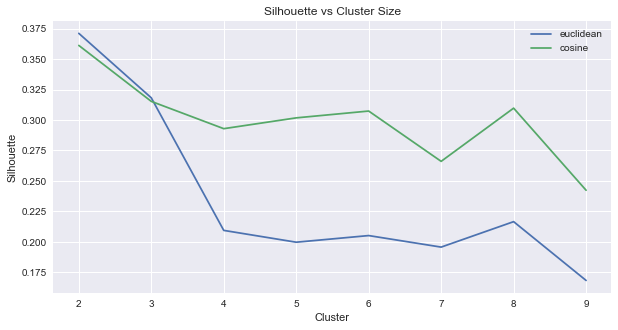

In [69]:
plt.figure(figsize=(10,5))
plt.plot(k,seuclid,label='euclidean')
plt.plot(k,scosine,label='cosine')
plt.ylabel("Silhouette")
plt.xlabel("Cluster")
plt.title("Silhouette vs Cluster Size")
plt.legend()
plt.show()

### Hierarchical Agglomerative Clustering - Visualizations

Jump to [top](#TOP)

In [70]:
hc = AgglomerativeClustering(n_clusters=2, affinity = 'cosine', linkage = 'average')
hc.fit(x_tune_slim)
hac_labels = hc.labels_

Text(0.5, 1.0, 'HAC (3 clusters, Euclidean, Average)')

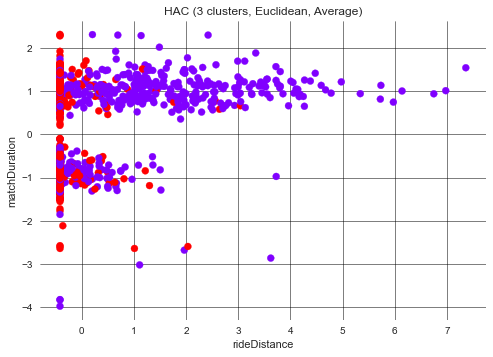

In [71]:
plt.scatter(x_tune_slim['rideDistance'],x_tune_slim['matchDuration'], c=hc.labels_, cmap = plt.cm.rainbow)
plt.xlabel('rideDistance')
plt.ylabel('matchDuration')
plt.grid(c='black',linewidth=0.5)
ax=plt.gca()
ax.set_facecolor('white')
plt.title('HAC (3 clusters, Euclidean, Average)')

Based on the scatter plot we created, we can determine that the clustering method doesn't produce a high degree of separation within our dataset. It seems that the clustering is very random since there isn't a clearly defined linear separation between our red and purple classes.

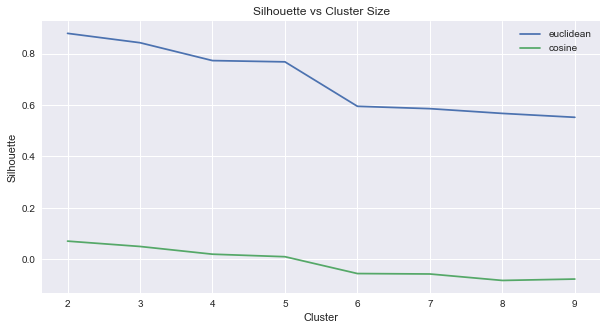

In [72]:
seuclid = []
scosine = []

k = range(2,10)
for i in k:
    hc_model = AgglomerativeClustering(n_clusters=i, linkage = 'average').fit(x_tune_slim)
    labels = hc_model.labels_
    seuclid.append(metrics.silhouette_score(x_tune_slim, labels, metric='euclidean'))
    scosine.append(metrics.silhouette_score(x_tune_slim, labels, metric='cosine'))
    
plt.figure(figsize=(10,5))
plt.plot(k,seuclid,label='euclidean')
plt.plot(k,scosine,label='cosine')
plt.ylabel("Silhouette")
plt.xlabel("Cluster")
plt.title("Silhouette vs Cluster Size")
plt.legend()
plt.show()

Comparing the Silhouette score for both Euclidean and Cosine, there is a clear similar trend between the distance metrics. However, Cosine's Silhouette score shows that its trend is hovering near 0, denoting overlapping clusters. Additionally, it goes below 0 which tells us that the data points are wrongly assinged to a cluster as we can see (above) in the scatter plot.

In [73]:
# MATCH DURATION + TOTAL DISTANCE (ON X_TEST)

x_match_total = x_test[['matchDuration','totalDistance']]
cls_match_total = KMeans(n_clusters=8, init='k-means++',random_state=17)
cls_match_total.fit(x_match_total)
newfeature_match_total = cls_match_total.labels_ # the labels from kmeans clustering
cv_match_total = StratifiedKFold(n_splits=10)
x_match_total = x_test.loc[:, cols_df]
y_match_total = y_test.loc[:, ('quart_binary')]
x_match_total = np.column_stack((x_match_total,pd.get_dummies(newfeature_match_total)))
acc_match_total = cross_val_score(clf,x_match_total,y=y_match_total,cv=cv_match_total)
print ("Average accuracy (with kmeans for matchDuration/totalDistance)= ", acc_match_total.mean()*100, "+-", acc_match_total.std()*100)

Average accuracy (with kmeans for matchDuration/totalDistance)=  92.10392019663368 +- 0.17108095385156977


In [74]:
# Agglomerative Clustering has memory-space error if run on full x_test
indices_slim2 = x_test.sample(n=2000, replace=False, random_state=17).index
x_test_slim = x_test.loc[indices_slim2, :]
y_test_slim = y_test.loc[indices_slim2, :]

In [75]:
cv_match_total = StratifiedKFold(n_splits=10)
x_test = x_test_slim.loc[:, cols_df]
y_test = y_test_slim.loc[:, ('quart_binary')]
acc_match_total1 = cross_val_score(clf,x_test,y=y_test,cv=cv_match_total)
print ("Average accuracy (with kmeans for matchDuration/totalDistance)= ", acc_match_total1.mean()*100, "+-", acc_match_total.std()*100)

Average accuracy (with kmeans for matchDuration/totalDistance)=  90.75 +- 0.17108095385156977


In [76]:
X = x_test.loc[:, cols_df]
y = y_test
cv = StratifiedKFold(n_splits=10)

# clf is the Random classifier model
acc1 = cross_val_score(clf, X=X, y=y, cv=cv)

print ("Baseline average accuracy = ", acc1.mean()*100, "+-", acc1.std()*100)

Baseline average accuracy =  90.75 +- 1.8200274723201293


Based on our final externally cross-validated test analysis, we find the KMeans process with `matchDuration` + `totalDistance` clusters (n=8) to be the best model for predicting `quart_binary`, our response of interest.

<a id='ME4'></a>

# **Modeling and Evaluation 4**

Jump to [Top](#TOP)

*Assignment: Summarize the ramifications.*

Clustering may help identify hidden trends and produce improved analysis, leveraging it in predicting `quart_binar` (our developed feature from the original `winPlacePerc` continuous variable). This ends up as the case for us as well, since it produced an improved prediction. Our final accuracy score from this model was **92.1039 +- 0.1711** as compared with the "baseline" RandomForestClassifier which had a score of **90.75 +- 1.8200** on the new, `x_test` data.

Due to the wider variance found in the RandomForest model, we do not expect the results to be verifiable via Student's t-test analysis. However, we would be hesitant to recommend this model to a client alone. While there *was* additional information to tease out of the data with clustering, it is unclear whether this is the most useful tool for PUBG placement predictions.

We suggest that the results we have found here could be used as a start for additional feature selection—specifically for ranked matches.

For future analysis, we may switch to F1-score analysis as an improved metric in prediction capability. Also, we would be interested in pursuing the Agglomerative Clustering mechanism if it was capable of processing larger amounts of information.

<a id='DEPLOYMENT'></a>

# **DEPLOYMENT**

Jump to [Top](#TOP)

*Assignment: Be critical of your performance and tell the reader how you current model might be usable by other parties.* 

**Q1: Did you achieve your goals?**

One of the limitations we artificially imposed on ourselves was removing the `matchID` and `groupID` classifiers. These categoricals were essential to the original winners of the Kaggle competition in helping them assign `winPlacePerc` in the most accurate fashion.

Our approach focused more on individual player stats, so this is a benefit of our model over theirs: ours is more generalizable.

While we did improve our prediction capabilities over the baseline *RandomForestClassifier*, the result isn't statistically significant. It is *practially* significant, and for that we are grateful for this exercise.

**Q2: If not, can you reign in the utility of your modeling?**

One of the strongest pieces of evidence for this model was the fact that we produced a smaller standard deviation than the Random Forest classifier.

**Q3: How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)?**

While this approach by itself isn't more useful than the RandomForestClassifier, it is important to note that not much more information can be extracted from player-stats alone.

**Q4: How would your deploy your model for interested parties?**

One possibility for deployment would be to generate an R-shiny application or convert our Python-based modeling into equivalent Javascript for a web-based deployment. This would be a tool that could be managed and updated by a team rather than giving full access to the client.

**Q5: What other data should be collected?**

If clients were interested in betting on well-known teams and individuals, we may be able to tailor this analysis to those specific requests. One of the downsides of the Kaggle data is that it is anonymized.

A different approach would be to utilize clustering and classification or regression models to generate strong team-pairings based on individual e-sport competitors' stats and strategies.

**Q6: How often would the model need to be updated, etc.?**

Thankfully, the model need only be updated whenever there is a major tournament or event in PUBG. It could be run more frequently depending on frequency of events, but typically this approach would only need to be done once, prior to the event.

<a id='EXCEPTIONAL'></a>

# **EXCEPTIONAL WORK**

Jump to [Top](#TOP)

*Assignment: You have free reign to provide additional analyses or combine analyses.*

* Performed additional EDA on attributes that might be useful for clusters.
* Performed additional T-Tests to assess KMEANS & HAC model parameters performance.
* Created additional (new) attributes to aid with our clusters.
* Utilized Silhouette score to inform modeling.

<a id='APPENDIX'></a>

# **APPENDIX**

Jump to [Top](#TOP)

## DATA DEFINITIONS

### Original variables

The first three attributes (see above)—*Id*, *groupID*, and *matchID*—are alpha-numeric identifiers for the players, the teams/groups, and the individual matches that players participated in. These are stored as objects but could also be identified as strings.

The variables of type integer are *assists*, *boosts*, *DBNO*s, *headshotKills*, *heals*, *killPlace*, *killPoints*, *kills*, *killStreaks*, *matchDuration*, *maxPlace*, *numGroups*, *rankPoints*, *revives*, *roadKills*, *teamKills*, *vehicleDestroys*, *weaponsAcquired*, and *winPoints*.

* DBNOs = Number of enemy players knocked. DBNO means “down but not out.” Essentially, “knocked” means to be knocked out. When a player is knocked, they lose their ability to shoot, move quickly, and to hold a gun. Players do not die instantly when knocked, when playing in a group (on a team) - other members of the team can revive a knocked player.

* assists = Number of enemy players this player damaged that were killed by teammates.

* boosts = Number of boost items used. Boost items are things that improve a player’s health, examples are energy drinks, painkillers, and adrenaline syringes.

* damageDealt = Total damage dealt. Note: Self inflicted damage is subtracted.

* headshotKills = Number of enemy players killed with headshots. 

* heals = Number of healing items used.
* Id - Player’s Id

* killPlace = Ranking in match of number of enemy players killed.

* killPoints = Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.

* killStreaks = Max number of enemy players killed in a short amount of time.

* kills = Number of enemy players killed.

* longestKill = Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.

* matchDuration = Duration of match in seconds.

* matchId = ID to identify match. There are no matches that are in both the training and testing set.

* matchType = String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.

* rankPoints = Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.

* revives = Number of times this player revived teammates.

* rideDistance = Total distance traveled in vehicles measured in meters.

* roadKills = Number of kills while in a vehicle.
* swimDistance - Total distance traveled by swimming measured in meters.

* teamKills = Number of times this player killed a teammate.

* vehicleDestroys = Number of vehicles destroyed.

* walkDistance = Total distance traveled on foot measured in meters.

* weaponsAcquired = Number of weapons picked up.

* winPoints = Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.

* groupId = ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.

* numGroups = Number of groups we have data for in the match.

* maxPlace = Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.

* winPlacePerc = The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match. (Higher is better.)

*Definitions pulled from Kaggle*: https://www.kaggle.com/c/pubg-finish-placement-prediction/data

*Additional details added to elaborate on/clarify some of the variables.*

### Variables we created <br/>

* healItems = sum of heals + boosts

* quart_binary = value is 0/1; if winPlacePerc in top quartile, value = 1, else 0.

* quart_int = numeric representation of the winPlacePerc quartile.

* quartile = varchar representation of quartile of winPlacePerc.

* totalDistance = sum of rideDistance + swimDistance + walkDistance.

* totalItems = sum of heals + boosts + weaponsAcquired.
